# Binary classification of dog/cat images with pretrained ConvNet

The previous notebook "Binary classification of dog and cat images" worked with a small dataset of images containing dogs and cats (2000 training, 1000 validation and 1000 test images). It constructed a ConvNet from scratch in Keras, and reached accuracy of 70% and 80%, respectively without and with image augmentation. 

This notebook uses the same dataset, and predicts the same output, but the model used is based on a large pretrained ConvNet called "VGG-16". We use an approach called "feature extraction" where we only keep the convolutional base of the network, discarding the fully connected layers on top, and use the base to convert input images of shape (150, 150, 3) into feature matrices of shape (4, 4, 512). In this way, the output contains features learned in the Conv base (eg. cat/dog eyes, mouth, nose...), but at the same time the information within an image is compressed down to a smaller matrix. These outputs, are then used as an input to a new fully connected neural network used to do the prediction of dog / cat. The resulting accuracy is around 90%, thus improved compared to previous approaches.

In [3]:
from keras.applications import VGG16

/Users/Misko/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


The following line is used to retrieve only the convolutional base of VGG-16, by passing the `include_top=False` argument. Printing the summary of the model shows that there are 13 convolutional layers and a few MaxPooling layers in between. The output is of shape (4, 4, 512). It's important to note that the network comes with pretrained weights, so it can directly be used to compute the outputs.

In [2]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

The following few lines of code define the image directories, and an ImageDataGenerator. The `extract_features` method will use the ImageDataGenerator to load images from file, normalize and pass them to the Conv base. Then the output of the Conv base is kept in arrays for the train, validation and test sets. These arrays are returned by the `extract_features` model.

In [5]:
base_dir = '/Users/Misko/PycharmProjects/Playfield/data/DogsCatsData'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

In [8]:
def extract_features(directory, sample_count):
    '''
    Flows images from file using a ImageDataGenerator into the convnet base 
    and saves the output features (and corresponding labels) in numpy arrays.
    '''
    
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory, target_size=(150, 150), batch_size=batch_size, class_mode='binary')

    i = 0
    for inputs_batch, labels_batch in generator:
        print("i =", i)
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        
        # Break generator once all samples are yielded
        if i * batch_size >= sample_count:
            break;
    return features, labels

In [ ]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

To use the Conv base output features in the next fully connected neural net, we'll need to flatten their data..

In [10]:
# Flatten arrays for input in a densly connected layer
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Now define a densly connected classifier with one hidden layer and a binary output, and train the model

In [13]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
             loss='binary_crossentropy',
             metrics=['acc'])

history = model.fit(train_features, train_labels,
                   epochs=30,
                   batch_size=20,
                   validation_data=(validation_features, validation_labels))


Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.6016 - acc: 0.6675 - val_loss: 0.4356 - val_acc: 0.8380
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4337 - acc: 0.8065 - val_loss: 0.3559 - val_acc: 0.8630
Epoch 3/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3697 - acc: 0.8385 - val_loss: 0.3145 - val_acc: 0.8820
Epoch 4/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.3116 - acc: 0.8710 - val_loss: 0.2911 - val_acc: 0.8910
Epoch 5/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2899 - acc: 0.8850 - val_loss: 0.2803 - val_acc: 0.8880
Epoch 6/30
2000/2000 [==============================] - 3s 2ms/step - loss: 0.2604 - acc: 0.8970 - val_loss: 0.2658 - val_acc: 0.8980
Epoch 7/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2449 - acc: 0.9055 - val_loss: 0.2672 - val_acc: 0.8860
Epoch 8/30
200

Finally we can check the loss function and accuracy over the epochs, for both the training and validation data..

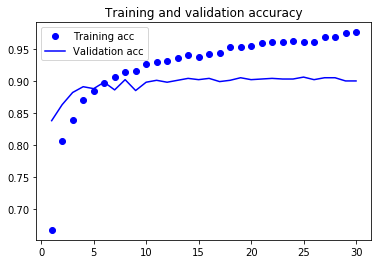

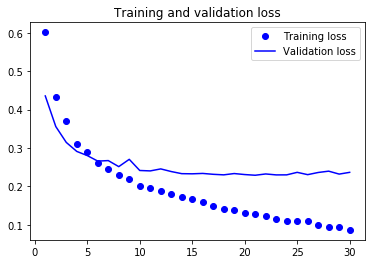

In [14]:
def plot_history(history):
    '''
    Plots training and validation loss and accuracy across epochs
    '''
    
    import matplotlib.pyplot as plt
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()
    
plot_history(history)

We can see we reached pretty good accuracy of 90% with a simple, 1 hidden layer, densly connected neural net. Of course, most of the  credits go to the convolutional base which was used to extract features from raw images.

Using a pretrained model in ConvNets is frequently done in practice. This is because: 1) it's expensive to train a large-scale model on a large dataset of images, 2) many of the features learned in a pretrained model can be transferred for use in a new model ("transfer learning"). 

Finally, there are also other ways to extract some benefits from using a pretrained model. For example, one way would be to append a fully connected layer to the Conv base and continue training all weights in the model on your own data. This could return even better results if your data is big enough. It's important to note that in this case it's better to use a small learning rate, so that already learned weights in the Conv base do not get destroyed, but slightly adjusted.

## References
- "Deep Learning with Python" book by Francois Chollet